In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
import torch
import numpy as np
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from inpainting.visualizations import samples as vis
from inpainting.visualizations.digits import digit_with_mask as vis_digit_mask
import pandas as pd
from inpainting.evaluation import evaluation as ev
from tqdm import tqdm
from itertools import chain
from inpainting.evaluation.frechet_models import MNISTNet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from inpainting.evaluation import fid
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader

In [4]:
experiments_paths = {
    "misgan": Path("../results/mnist/misgan/"),
    "gmm_only_hidden": Path("../results/mnist/misgan_like/14x14/"),
    "gmm_missing_and_hidden": Path("../results/mnist/misgan_like/14x14_two_holes/")

    
}

In [5]:
experiments_results = dict()

for (name, path) in experiments_paths.items():
    with (path / "val_predictions.pkl").open("rb") as f:
        experiments_results[name] = pickle.load(f)

In [6]:
experiments_images = dict()

for (name, results) in experiments_results.items():
    experiments_images[name] = [(ev.outputs_to_images(*r), r[-1]) for r in results]

# Skimage metrics

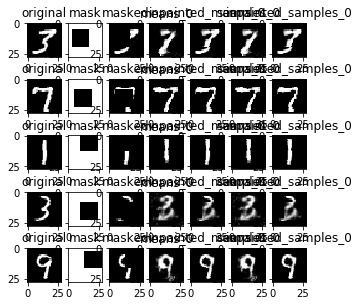

In [7]:
def plot_exp_images(images_dicts, figsize=(15,15)):
    width = len(images_dicts[0][0])
    height = len(images_dicts)
    fig, ax = plt.subplots(height,width, figsize=figsize)
    for i, (imgs, label) in enumerate(images_dicts):
        for j, (k, v) in enumerate(imgs.items()):
            ax[i][j].imshow(v.squeeze(), cmap="gray")
            ax[i][j].set_title(k)

plot_exp_images(experiments_images["misgan"][:5], figsize=(5,5))

In [8]:
experiments_metrics = {
    name: [
        {
            "metrics": ev.images_metrics(img_dict),
            "label": label
        }
        for (img_dict, label) in tqdm(img_dicts)
    ]
    for name, img_dicts in experiments_images.items()
}

  0%|          | 0/10000 [00:00<?, ?it/s]/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
/home/mprzewiezlikowski/anaconda3/envs/uj/lib/python3.7/site-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
../inpainting/evaluation/evaluation.py:82: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  "peak_signal_noise_ratio": lambda i1, i2,: peak_signal_noise_ratio(i1, i2)
100%|██████████| 10000/10000 [01:24<00:00, 118.40it/s]


In [46]:
per_image_metrics_df = pd.DataFrame([
    {
        "imputer_model": model,
        "label": label_metric["label"],
        **metric
    }
    for model, label_metrics in experiments_metrics.items()
    for label_metric in label_metrics
    for metric in label_metric["metrics"] #if metric["img_kind"] #in ["inpainted_means_0", "inpainted_samples_0"]
])
per_image_metrics_df

,imputer_model,label,img_kind,structural_similarity,peak_signal_noise_ratio
0,misgan,3,original,1.000000,inf
1,misgan,3,mask,-0.018351,1.499226
2,misgan,3,masked,0.640563,12.955039
3,misgan,3,means_0,0.575092,11.611971
4,misgan,3,inpainted_means_0,0.845908,17.332995
...,...,...,...,...,...
209995,gmm_missing_and_hidden,4,masked,0.481284,11.298904
209996,gmm_missing_and_hidden,4,means_0,0.675583,15.671537
209997,gmm_missing_and_hidden,4,inpainted_means_0,0.731968,16.094678
209998,gmm_missing_and_hidden,4,samples_0,0.424291,11.492574


In [49]:
per_image_metrics_df.drop("label", axis=1).groupby(
    ["imputer_model", "img_kind"]
).agg(
    lambda pts: "{0:.2f} ± {1:.2f}".format(np.mean(pts), np.std(pts) )
     ).reset_index().to_csv("ssim_psnr.csv")

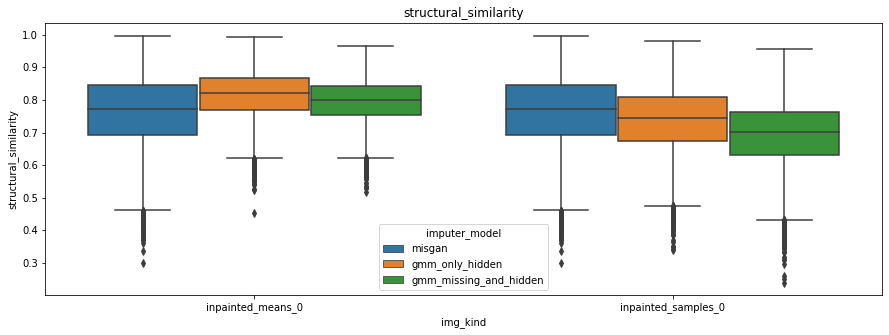

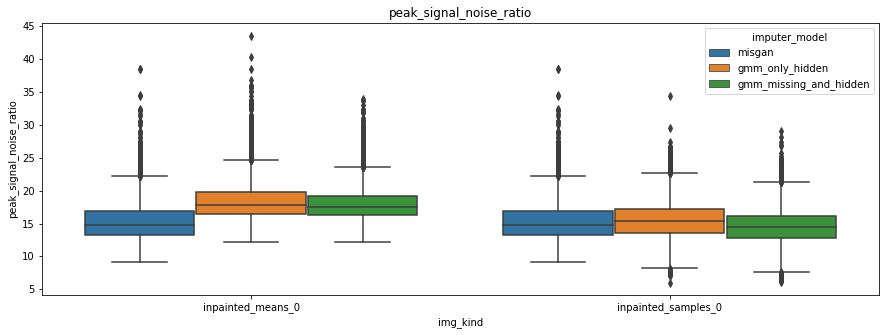

In [20]:
for metric in ["structural_similarity", "peak_signal_noise_ratio"]:
    plt.figure(figsize=(15, 5))
    plt.title(metric)
    sns.boxplot(
        data=per_image_metrics_df,
        y=metric,
        x="img_kind",
        hue="imputer_model"
    )
    plt.show()

# Frechet distance

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

ds_train = MNIST(Path.home() / "uj" / "data", train=True, download=True, transform=ToTensor())
ds_val = MNIST(Path.home() / "uj" / "data", train=False, download=True, transform=ToTensor())

dl_train = DataLoader(ds_train, 1024, shuffle=True)
dl_val = DataLoader(ds_val, 256, shuffle=False)

classifier = MNISTNet()
opt = Adam(classifier.parameters(), 4e-3)
loss_fn = CrossEntropyLoss()

classifier.to(device)
for i in range(5):
    classifier.train()
    for X, y in tqdm(dl_train):
        opt.zero_grad()
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
    classifier.eval()
    accs = []
    for (X,y ) in dl_val:
        X, y = [t.to(device) for t in [X, y]]
        y_pred, _ = classifier(X)
        logits = y_pred.argmax(1)
        accs.append(accuracy_score(y.cpu().numpy(), logits.cpu().numpy()))
    print(i, np.mean(accs))

cpu





  0%|          | 0/59 [00:00<?, ?it/s]


  2%|▏         | 1/59 [00:08<08:24,  8.69s/it]


  3%|▎         | 2/59 [00:17<08:22,  8.81s/it]


  5%|▌         | 3/59 [00:23<07:16,  7.80s/it]


  7%|▋         | 4/59 [00:31<07:11,  7.84s/it]


  8%|▊         | 5/59 [00:40<07:28,  8.31s/it]


 10%|█         | 6/59 [00:47<06:58,  7.90s/it]


 12%|█▏        | 7/59 [00:56<07:02,  8.13s/it]


 14%|█▎        | 8/59 [01:02<06:27,  7.59s/it]


 15%|█▌        | 9/59 [01:07<05:35,  6.71s/it]


 17%|█▋        | 10/59 [01:12<05:07,  6.28s/it]


 19%|█▊        | 11/59 [01:17<04:39,  5.82s/it]


 20%|██        | 12/59 [01:22<04:24,  5.62s/it]


 22%|██▏       | 13/59 [01:27<04:05,  5.34s/it]


 24%|██▎       | 14/59 [01:31<03:50,  5.13s/it]


 25%|██▌       | 15/59 [01:37<03:57,  5.39s/it]


 27%|██▋       | 16/59 [01:43<03:51,  5.38s/it]


 29%|██▉       | 17/59 [01:51<04:19,  6.17s/it]


 31%|███       | 18/59 [01:57<04:19,  6.33s/it]


 32%|███▏      | 19/59 [02:04<04:19,  6.49s/it]


 34%|███▍      

0 0.94208984375





  2%|▏         | 1/59 [00:08<08:34,  8.87s/it]


  3%|▎         | 2/59 [00:17<08:22,  8.82s/it]


  5%|▌         | 3/59 [00:25<07:52,  8.44s/it]


  7%|▋         | 4/59 [00:33<07:36,  8.31s/it]


  8%|▊         | 5/59 [00:39<06:52,  7.63s/it]


 10%|█         | 6/59 [00:46<06:40,  7.56s/it]


 12%|█▏        | 7/59 [00:54<06:41,  7.72s/it]


 14%|█▎        | 8/59 [01:02<06:30,  7.66s/it]


 15%|█▌        | 9/59 [01:10<06:34,  7.89s/it]


 17%|█▋        | 10/59 [01:17<06:16,  7.68s/it]


 19%|█▊        | 11/59 [01:24<05:56,  7.42s/it]


 20%|██        | 12/59 [01:32<06:01,  7.70s/it]


 22%|██▏       | 13/59 [01:40<05:49,  7.59s/it]


 24%|██▎       | 14/59 [01:48<05:46,  7.69s/it]


 25%|██▌       | 15/59 [01:56<05:46,  7.87s/it]


 27%|██▋       | 16/59 [02:05<05:54,  8.24s/it]


 29%|██▉       | 17/59 [02:11<05:15,  7.50s/it]


 31%|███       | 18/59 [02:17<04:55,  7.20s/it]


 32%|███▏      | 19/59 [02:25<04:50,  7.27s/it]


 34%|███▍      | 20/59 [02:32<04:47,  7.37s/it]


 36%|█

1 0.968359375





  2%|▏         | 1/59 [00:07<07:33,  7.82s/it]


  3%|▎         | 2/59 [00:15<07:31,  7.92s/it]


  5%|▌         | 3/59 [00:23<07:12,  7.72s/it]


  7%|▋         | 4/59 [00:31<07:11,  7.85s/it]


  8%|▊         | 5/59 [00:38<06:48,  7.57s/it]


 10%|█         | 6/59 [00:45<06:42,  7.59s/it]


 12%|█▏        | 7/59 [00:53<06:41,  7.72s/it]


 14%|█▎        | 8/59 [00:59<06:00,  7.08s/it]


 15%|█▌        | 9/59 [01:06<05:55,  7.10s/it]


 17%|█▋        | 10/59 [01:15<06:13,  7.62s/it]


 19%|█▊        | 11/59 [01:23<06:11,  7.75s/it]


 20%|██        | 12/59 [01:30<05:54,  7.55s/it]


 22%|██▏       | 13/59 [01:38<05:48,  7.58s/it]


 24%|██▎       | 14/59 [01:45<05:38,  7.51s/it]


 25%|██▌       | 15/59 [01:53<05:36,  7.64s/it]


 27%|██▋       | 16/59 [01:59<05:07,  7.15s/it]


 29%|██▉       | 17/59 [02:04<04:33,  6.51s/it]


 31%|███       | 18/59 [02:09<04:09,  6.07s/it]


 32%|███▏      | 19/59 [02:14<03:49,  5.73s/it]


 34%|███▍      | 20/59 [02:19<03:33,  5.48s/it]


 36%|█

2 0.97607421875





  2%|▏         | 1/59 [00:05<05:24,  5.60s/it]


  3%|▎         | 2/59 [00:09<04:57,  5.22s/it]


  5%|▌         | 3/59 [00:14<04:39,  4.98s/it]


  7%|▋         | 4/59 [00:18<04:19,  4.71s/it]


  8%|▊         | 5/59 [00:22<04:03,  4.52s/it]


 10%|█         | 6/59 [00:27<04:00,  4.53s/it]


 12%|█▏        | 7/59 [00:32<04:02,  4.67s/it]


 14%|█▎        | 8/59 [00:38<04:18,  5.07s/it]


 15%|█▌        | 9/59 [00:44<04:33,  5.47s/it]


 17%|█▋        | 10/59 [00:50<04:40,  5.73s/it]


 19%|█▊        | 11/59 [00:58<05:02,  6.30s/it]


 20%|██        | 12/59 [01:06<05:17,  6.76s/it]


 22%|██▏       | 13/59 [01:13<05:13,  6.81s/it]


 24%|██▎       | 14/59 [01:19<05:00,  6.68s/it]


 25%|██▌       | 15/59 [01:26<05:01,  6.84s/it]


 27%|██▋       | 16/59 [01:35<05:15,  7.33s/it]


 29%|██▉       | 17/59 [01:43<05:24,  7.73s/it]


 31%|███       | 18/59 [01:51<05:16,  7.72s/it]


 32%|███▏      | 19/59 [01:58<04:58,  7.47s/it]


 34%|███▍      | 20/59 [02:07<05:04,  7.81s/it]


 36%|█

3 0.97998046875





  2%|▏         | 1/59 [00:06<06:33,  6.78s/it]


  3%|▎         | 2/59 [00:15<06:51,  7.23s/it]


  5%|▌         | 3/59 [00:22<06:54,  7.40s/it]


  7%|▋         | 4/59 [00:30<06:52,  7.49s/it]


  8%|▊         | 5/59 [00:38<06:47,  7.54s/it]


 10%|█         | 6/59 [00:46<06:58,  7.90s/it]


 12%|█▏        | 7/59 [00:54<06:38,  7.67s/it]


 14%|█▎        | 8/59 [01:02<06:42,  7.89s/it]


 15%|█▌        | 9/59 [01:09<06:23,  7.68s/it]


 17%|█▋        | 10/59 [01:16<05:59,  7.34s/it]


 19%|█▊        | 11/59 [01:23<05:48,  7.27s/it]


 20%|██        | 12/59 [01:31<05:48,  7.42s/it]


 22%|██▏       | 13/59 [01:38<05:41,  7.42s/it]


 24%|██▎       | 14/59 [01:45<05:33,  7.41s/it]


 25%|██▌       | 15/59 [01:53<05:33,  7.57s/it]


 27%|██▋       | 16/59 [02:00<05:11,  7.23s/it]


 29%|██▉       | 17/59 [02:07<05:02,  7.20s/it]


 31%|███       | 18/59 [02:13<04:36,  6.73s/it]


 32%|███▏      | 19/59 [02:18<04:14,  6.35s/it]


 34%|███▍      | 20/59 [02:23<03:56,  6.06s/it]


 36%|█

4 0.98076171875


In [40]:
def images_loader(
    images,
    batch_size = 256
):
    return DataLoader(
        TensorDataset(
            torch.Tensor([
                img.transpose(2, 0, 1)
                for img in images
            ])
        ),
        batch_size=batch_size
    )
    

def frechet_distance(
    images_loader_1,
    images_loader_2,
    model=classifier
):
    (mu_1, s_1), (mu_2, s_2) = [
        fid.calculate_activation_statistics(
            il,
            len(il.dataset),
            model,
            feature_dim=128,
        )
        for il in [images_loader_1, images_loader_2]
    ]
    return fid.calculate_frechet_distance(
        mu_1, s_1, mu_2, s_2
    )

def grouped_by_kinds(images_dicts):
    return {
        k: [
            i_d[k] for (i_d, _) in images_dicts
        ]
        for k in images_dicts[0][0].keys()
    }
    


In [41]:
experiments_images_by_kinds = {
    name: grouped_by_kinds(img_dicts)
    for name, img_dicts in experiments_images.items()
}

In [42]:
frechet_dists = {
    name: {
        kind: frechet_distance(
            images_loader(kind_to_images["original"]),
            images_loader(images)
            )
        for kind, images in kind_to_images.items()
    }
    for name, kind_to_images in experiments_images_by_kinds.items()
}

In [43]:
frechet_dists_df = pd.DataFrame([
    {
        "imputer_model": name,
        "kind": kind,
        "frechet_distance": fd
    }
    for name, kind_to_fd in frechet_dists.items()
    for kind, fd in kind_to_fd.items()
])

frechet_dists_df

,imputer_model,kind,frechet_distance
0,misgan,original,-2.842171e-14
1,misgan,mask,3.437740e+01
2,misgan,masked,9.416556e+00
3,misgan,means_0,2.522010e+00
4,misgan,inpainted_means_0,8.363649e-01
5,misgan,samples_0,2.522010e+00
6,misgan,inpainted_samples_0,8.363649e-01
7,gmm_only_hidden,original,2.842171e-14
8,gmm_only_hidden,mask,3.439526e+01
9,gmm_only_hidden,masked,9.412125e+00


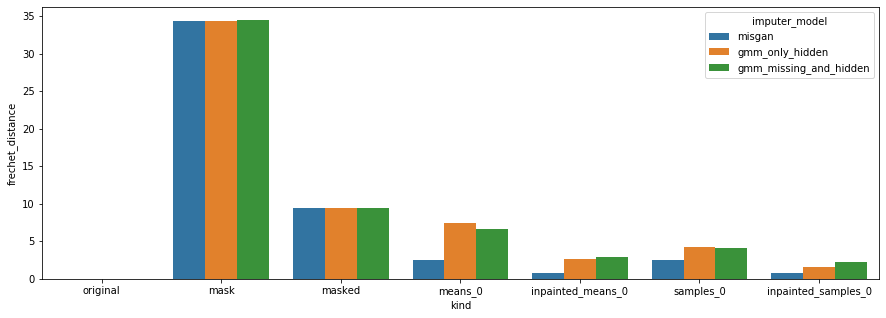

In [44]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=frechet_dists_df,
    y="frechet_distance",
    x="kind",
    hue="imputer_model",
)

In [45]:
frechet_dists_df.to_csv("frechet_dists_tmp.csv")